# Gridsearch

### Imports, Loading, Functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

**Custom Functions**

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [17]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

**Load and prepare data**

In [9]:
df = pd.read_csv('Data/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
# Change the Month column to datetime
df['Month'] = pd.to_datetime(df['Month'])
# Set the Month column to the index
df = df.set_index('Month')
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Data is monthly at the start of the month, so freq will be seet to 'MS'
- Define the time series with the '#Passengers' data and plot the data.

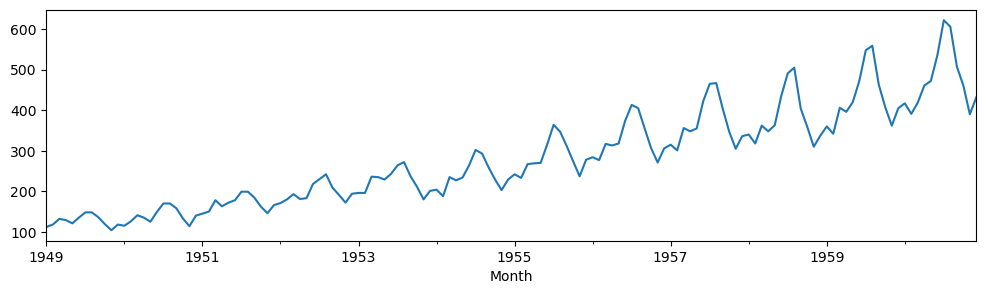

In [11]:
# Set frequency to first day of the month
df = df.asfreq('MS')
# Define the time series
ts = df['#Passengers']
ts.plot();

### Beginning Modeling

**Checking Seasonality**

- There appears to be some seasonality. Decomp the model and explore seasonal aspect.

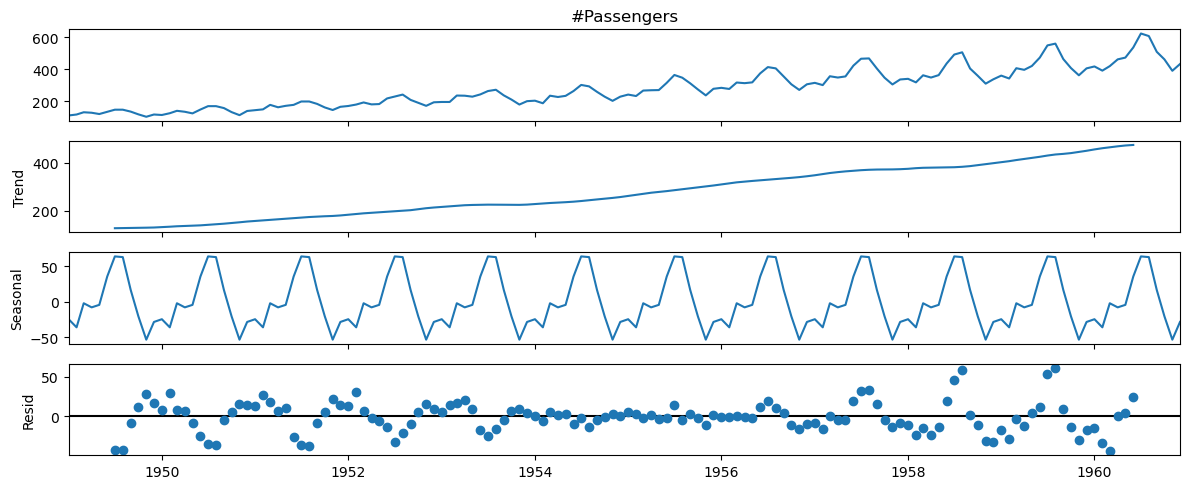

In [12]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [14]:
## How impactful is the seasonal component?
# Get seasonal compt size
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is seasonal compt relative to time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.") 

The seasonal component is  117.42 which is ~22.67% of the variation in time series.


- Next is determining the period of the seasonal component. Try 'zooming in' on the plot by filtering for a range of years, 1954-1956.
- Adding a distinctive marker allows counting periods easily.

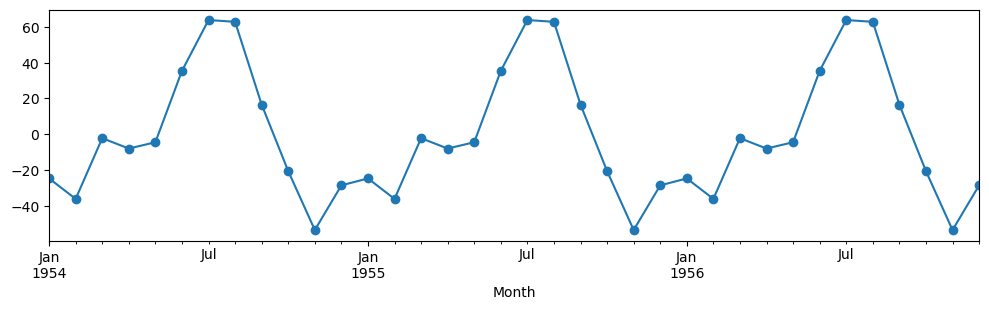

In [15]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['1954':'1956'].plot(marker = 'o')

- It can be seen the seasonal period is 12.

**Checking for stationarity and determine differencing**

In [18]:
# Check for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.815369,13,130,0.99188,0.05,False


In [20]:
## Determine the value of (d) and (D)
d = ndiffs(ts)
print(f'd = {d}')

D = nsdiffs(ts, m=12)
print(f'D = {D}')

d = 1
D = 1


- This case requires both seasonal and nonseasonal differencing, so use .diff(12)

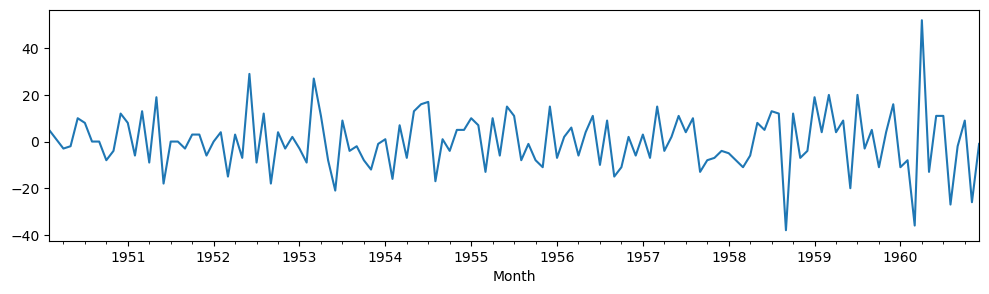

In [21]:
# Apply the differencing
ts_diff = ts.diff().diff(12).dropna()
ts_diff.plot();

**Estimating model orders**
- Explore ACF/PACF plots of the differenced data.
- Annotate seasonal lags to assist with estimation of seasonal components.

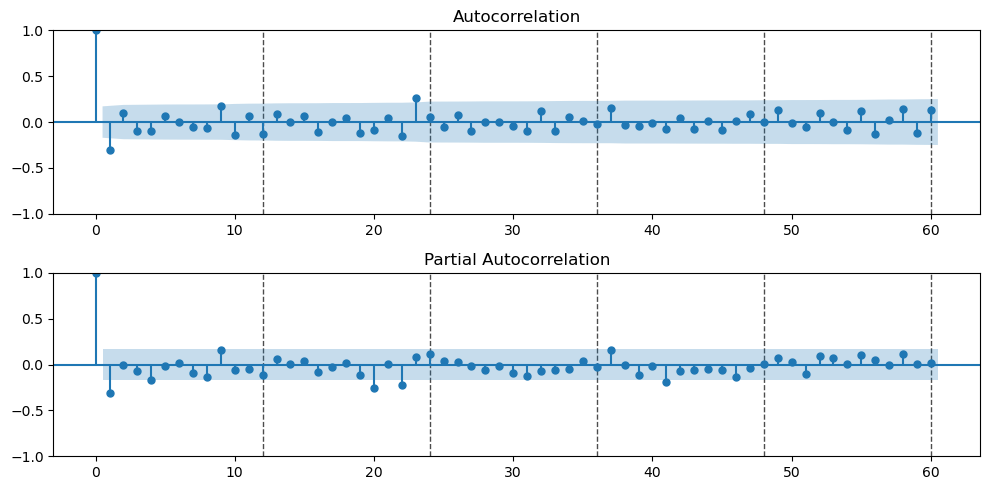

In [22]:
# Examine ACF/PACF of the stationary data
plot_acf_pacf(ts_diff, annotate_seas = True, m=12, nlags=60);

- The plots do not show obvious values for orders. there is a drop after the first lag for both ACF/PACF. Here a 1 for either AR or MA could be used.
- Seasonal lags in both plots gradually decline, so try P and Q at 1.
- Remember this is just a starting point, not the final model.

### TTS

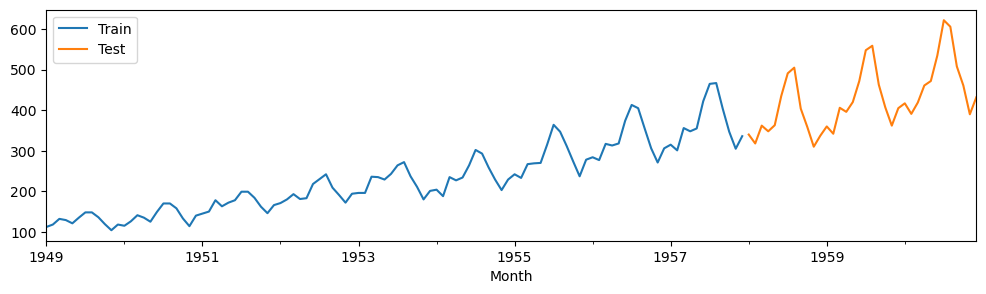

In [23]:
# tts
train, test = train_test_split(ts, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [24]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  108
Model:             ARIMA(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -348.996
Date:                            Wed, 06 Dec 2023   AIC                            705.993
Time:                                    18:48:23   BIC                            716.208
Sample:                                01-01-1949   HQIC                           710.121
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2298      0.097     -2.368      0.018      -0.420      -0.040
ar.S.L12      -0.3647      0.648     -0.563      0.574      -1.635       0.906
ma.S.L12       0.2274      0.705      0.323      0.747      -1.153       1.608
sigma2        90.5611     14.385      6.295      0.000      62.366     118.756
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.92   Prob(JB):                         0.29
Heteroskedasticity (H):               1.17   Skew:                             0.37
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Seasonal lags were shown to be insignificant, so the model would be okay if we removed them.